In [2]:
import timm
import torch
import wandb
import fastai
import dill
import re
import random
from sklearn.utils.class_weight import compute_class_weight
from fastai.callback.wandb import WandbCallback
from fastai.vision.all import *
from fastai.vision.core import *
from fastai.text.core import RegexLabeller
from fastai.vision.utils import get_image_files
from fastai.data.block import DataBlock
from fastai.data.core import *
from fastai.tabular.all import *
from torchvision.transforms import GaussianBlur
os.environ['WANDB_NOTEBOOK_NAME'] = 'Parameter_Optimization_Sweep.ipynb'

In [2]:
# define configs and parameters
# define static parameters
meta_config = SimpleNamespace(
    dataset_path = r"/blue/hulcr/gmarais/Beetle_data/selected_images/train_data",
    img_size=224,
    seed=42,
    project="Ambrosia_Symbiosis",
    # group="Beetle_classifier",
    # job_type="parameter_optimization"
    )

# define parameter optimization config
sweep_config = {
    'name': 'Beetle_Classifier_Sweep',
    'project':meta_config.project,
    'method': 'bayes',
    # 'run_cap':100,
    'metric': {
        'goal': 'minimize', 
        'name': 'validation_loss'
        },
    # 'early_terminate':{
    #     'type': 'hyperband',
    #     'min_iter': 1,
    #     'max_iter': 100,
    #     'eta': 3,
    #     's': 2
    # },
    'parameters': {
        'pretrained':{'values': [True, False]},
        'model_name':{'values': ['resnet50', 'maxvit_rmlp_small_rw_224.sw_in1k', 'maxvit_rmlp_base_rw_224.sw_in12k', 'maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k', 'vit_huge_patch14_224.orig_in21k']},
        'batch_size': {'values': [8, 16, 32, 64]},
        'epochs': {'max': 20, 'min': 1},
        'lr':{'min':1e-8,'max': 1e-1}
     }
}

In [3]:
# Define a custom transform for Gaussian blur
def gaussian_blur(x, p=0.5, kernel_size_min=3, kernel_size_max=20, sigma_min=0.1, sigma_max=3):
    if x.ndim == 4:
        for i in range(x.shape[0]):
            if random.random() < p:
                kernel_size = random.randrange(kernel_size_min, kernel_size_max + 1, 2)
                sigma = random.uniform(sigma_min, sigma_max)
                x[i] = GaussianBlur(kernel_size=kernel_size, sigma=sigma)(x[i])
    return x

def get_images(dataset_path, batch_size, img_size, seed, subfolders=('train','valid')):
    "The beetles dataset"
    files = get_image_files(path=dataset_path, recurse=True, folders=subfolders)
    transforms = aug_transforms(    # transformatiosn that are only applied ot training and not inference
                           batch=False,
                           pad_mode='zeros',
                           size=img_size,
                           p_affine=0.8,
                           p_lighting=0.8,
                           max_rotate=360.0,
                           mult=1.0, 
                           do_flip=True, 
                           flip_vert=False,
                           min_zoom=1.0,
                           max_zoom=1.1, 
                           max_lighting=0.75,
                           max_warp=0.2, 
                           mode='bilinear', 
                           align_corners=True,
                           min_scale=1.0,
                           xtra_tfms=[RandomErasing(p=0.8, max_count=5, sh=0.25)]) # this adds random erasing to entire batches
    transforms.append(partial(gaussian_blur, p=0.8))
    transforms.append(Normalize.from_stats(*imagenet_stats))
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       splitter = GrandparentSplitter(train_name=subfolders[0], valid_name=subfolders[1]),
                       get_y = parent_label,
                       item_tfms = Resize(img_size, ResizeMethod.Pad, pad_mode='zeros'), # resize trasnformation is applied during inference too                                    
                       batch_tfms = transforms)
    dls = dblock.dataloaders(dataset_path, bs = batch_size)
    return dls

def train(meta_config):
    "Train the model using the supplied configs"
    run = wandb.init(project=meta_config.project) # , job_type=meta_config.job_type, group =meta_config.group, 
    dls = get_images(dataset_path=meta_config.dataset_path, img_size=meta_config.img_size, seed=meta_config.seed, batch_size=wandb.config.batch_size)
    labels = np.array([re.split(r'/|\\', str(x))[-2] for x in dls.items])
    classes = np.unique(labels)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
    class_weights = {c: w for c, w in zip(classes, weights)}
    weights = tensor([class_weights[c] for c in dls.vocab]).to(dls.device)
    cbs = [MixedPrecision(), ShowGraphCallback(), SaveModelCallback(), WandbCallback(log='all')] 
    learn = vision_learner(dls, 
                           wandb.config.model_name,
                           loss_func=LabelSmoothingCrossEntropy(weight=weights),
                           metrics=[error_rate, 
                                    accuracy, 
                                    top_k_accuracy], 
                           cbs=cbs, 
                           pretrained=wandb.config.pretrained)
    learn.fine_tune(wandb.config.epochs, base_lr=wandb.config.lr)
    run.finish()
    
# Prepare training wrapper based on configs
def train_wrapper():
    train(meta_config = meta_config)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find Parameter_Optimization_Sweep.ipynb.


Create sweep with ID: 9fubrsfu
Sweep URL: https://wandb.ai/christopher-marais/Ambrosia_Symbiosis/sweeps/9fubrsfu


wandb: Agent Starting Run: s5ur9zpz with config:
wandb: 	batch_size: 8
wandb: 	epochs: 14
wandb: 	lr: 0.09200998111050764
wandb: 	model_name: maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k
wandb: 	pretrained: True
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find Parameter_Optimization_Sweep.ipynb.
wandb: Currently logged in as: christopher-marais. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/blue/hulcr/gmarais/conda/envs/BC_310/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,10.608073,227.423416,0.202893,0.797107,0.926343,13:01


Better model found at epoch 0 with valid_loss value: 227.4234161376953.


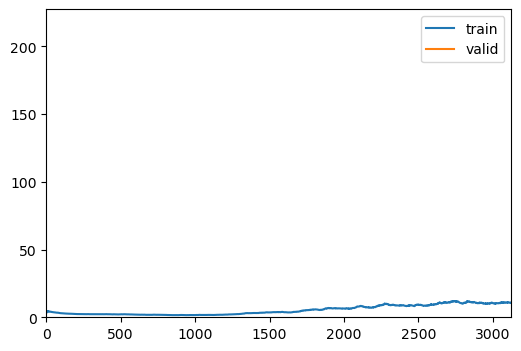

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.842107,29.590431,0.120530,0.879470,0.950047,17:55
1,1.034059,27.088350,0.136199,0.863801,0.965850,17:35
2,1.980238,34.810020,0.240391,0.759609,0.963439,17:33
3,2.406326,308.908264,0.280702,0.719298,0.873309,18:20
4,1.844706,nan,0.130039,0.869961,0.930226,17:45
5,1.276220,nan,0.149859,0.850141,0.985670,17:46
6,1.175229,nan,0.096960,0.903040,0.978037,17:44
7,0.844197,30.623192,0.044462,0.955538,0.990224,18:17
8,0.754127,15.649798,0.029999,0.970001,0.976831,17:52
9,0.662658,2.373693,0.022231,0.977769,0.999732,17:57


Better model found at epoch 0 with valid_loss value: 29.590431213378906.


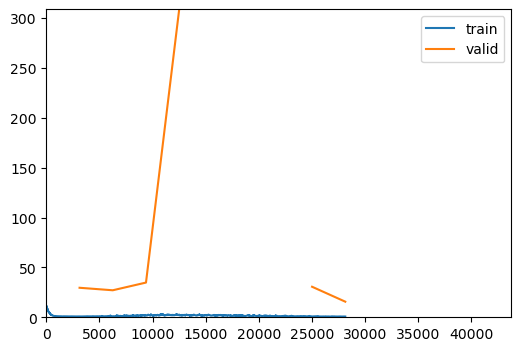

Better model found at epoch 1 with valid_loss value: 27.088350296020508.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 8 with valid_loss value: 15.649798393249512.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 9 with valid_loss value: 0.538946270942688.
Better model found at epoch 10 with valid_loss value: 0.5355876684188843.
Better model found at epoch 11 with valid_loss value: 0.5340772271156311.


In [ ]:
# Run sweep    
sweep_id = wandb.sweep(sweep_config)
sweep_id = "lzlixbyw"
wandb.agent(sweep_id, function=train_wrapper)